In [1]:
import os
from glob import glob

import climlab
import matplotlib.pyplot as plt
import numpy as np
import torch
import xarray as xr

SEED = 42
np.random.seed(SEED)

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl-fedrl"
RECORDS_DIR = f"{BASE_DIR}/records"
IMGS_DIR = f"{BASE_DIR}/results/imgs"

EXP_ID = "ebm-v1-optim-L-20k"
RL_ALGO = "ddpg"
SEED = 3
NUM_STEPS = 200

In [3]:
record_files = glob(
    f"{RECORDS_DIR}/infx10_*{EXP_ID}*/*{RL_ALGO}_torch__{SEED}*/*{NUM_STEPS}.pth"
)
ebm_dict = {}

for fp in record_files:
    step = int(fp.split("_")[-1].split(".")[0])
    with open(fp, "rb") as f:
        ebm_dict[step] = torch.load(f)

ebm_dict[200]["obs"] = np.concatenate(
    (ebm_dict[200]["obs"], ebm_dict[200]["next_obs"][-1:])
)

In [4]:
DATASETS_DIR = f"{BASE_DIR}/datasets"

fp_Ts = f"{DATASETS_DIR}/skt.sfc.mon.1981-2010.ltm.nc"
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"


def download_and_save_dataset(url, filepath, dataset_name):
    if not os.path.exists(filepath):
        print(f"Downloading {dataset_name} data ...")
        dataset = xr.open_dataset(url, decode_times=False)
        dataset.to_netcdf(filepath, format="NETCDF3_64BIT")
        print(f"{dataset_name} data saved to {filepath}")
    else:
        print(f"Loading {dataset_name} data ...")
        dataset = xr.open_dataset(
            filepath,
            decode_times=xr.coders.CFDatetimeCoder(use_cftime=True),
        )
    return dataset


ncep_Ts = download_and_save_dataset(
    ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc",
    fp_Ts,
    "NCEP surface temperature",
).sortby("lat")

lat_ncep = ncep_Ts.lat
lon_ncep = ncep_Ts.lon
Ts_ncep_annual = ncep_Ts.skt.mean(dim=("lon", "time"))

Loading NCEP surface temperature data ...


In [5]:
a0_ref = 0.354
a2_ref = 0.25
D_ref = 0.6
A_ref = 2.1
B_ref = 2.0

num_lat = 96

In [6]:
climlab_ebm = climlab.EBM_annual(
    a0=a0_ref,
    a2=a2_ref,
    D=D_ref,
    A=A_ref * 1e2,  # effective A (around 210)
    B=A_ref,
    num_lat=num_lat,
)
climlab_ebm.Ts[:] = 50.0  # initialise temperature state

climlab_ebm.Ts[:] = 50
climlab_ebm_obs = []

for i in range(NUM_STEPS):
    climlab_ebm_obs.append(np.array(climlab_ebm.Ts))
    climlab_ebm.step_forward()

climlab_ebm_obs = np.array(climlab_ebm_obs).squeeze()

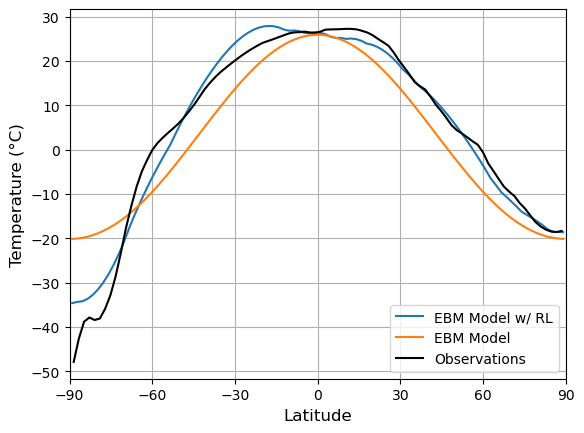

In [7]:
fig = plt.figure()
ax = fig.gca()

ebm_lat = climlab_ebm.lat
ebm_Ts = ebm_dict[200]["next_obs"][-1].reshape(-1)

ax.plot(ebm_lat, ebm_Ts, label="EBM Model w/ RL")
ax.plot(climlab_ebm.lat, climlab_ebm.Ts, label="EBM Model")
ax.plot(lat_ncep, Ts_ncep_annual, label="Observations", c="k")
ax.set_ylabel("Temperature (°C)", fontsize=12)
ax.set_xlabel("Latitude", fontsize=12)
ax.set_xlim(-90, 90)
ax.set_xticks(np.arange(-90, 91, 30))
ax.tick_params(axis="both", which="major", labelsize=10)

ax.legend(fontsize=10)
ax.grid()

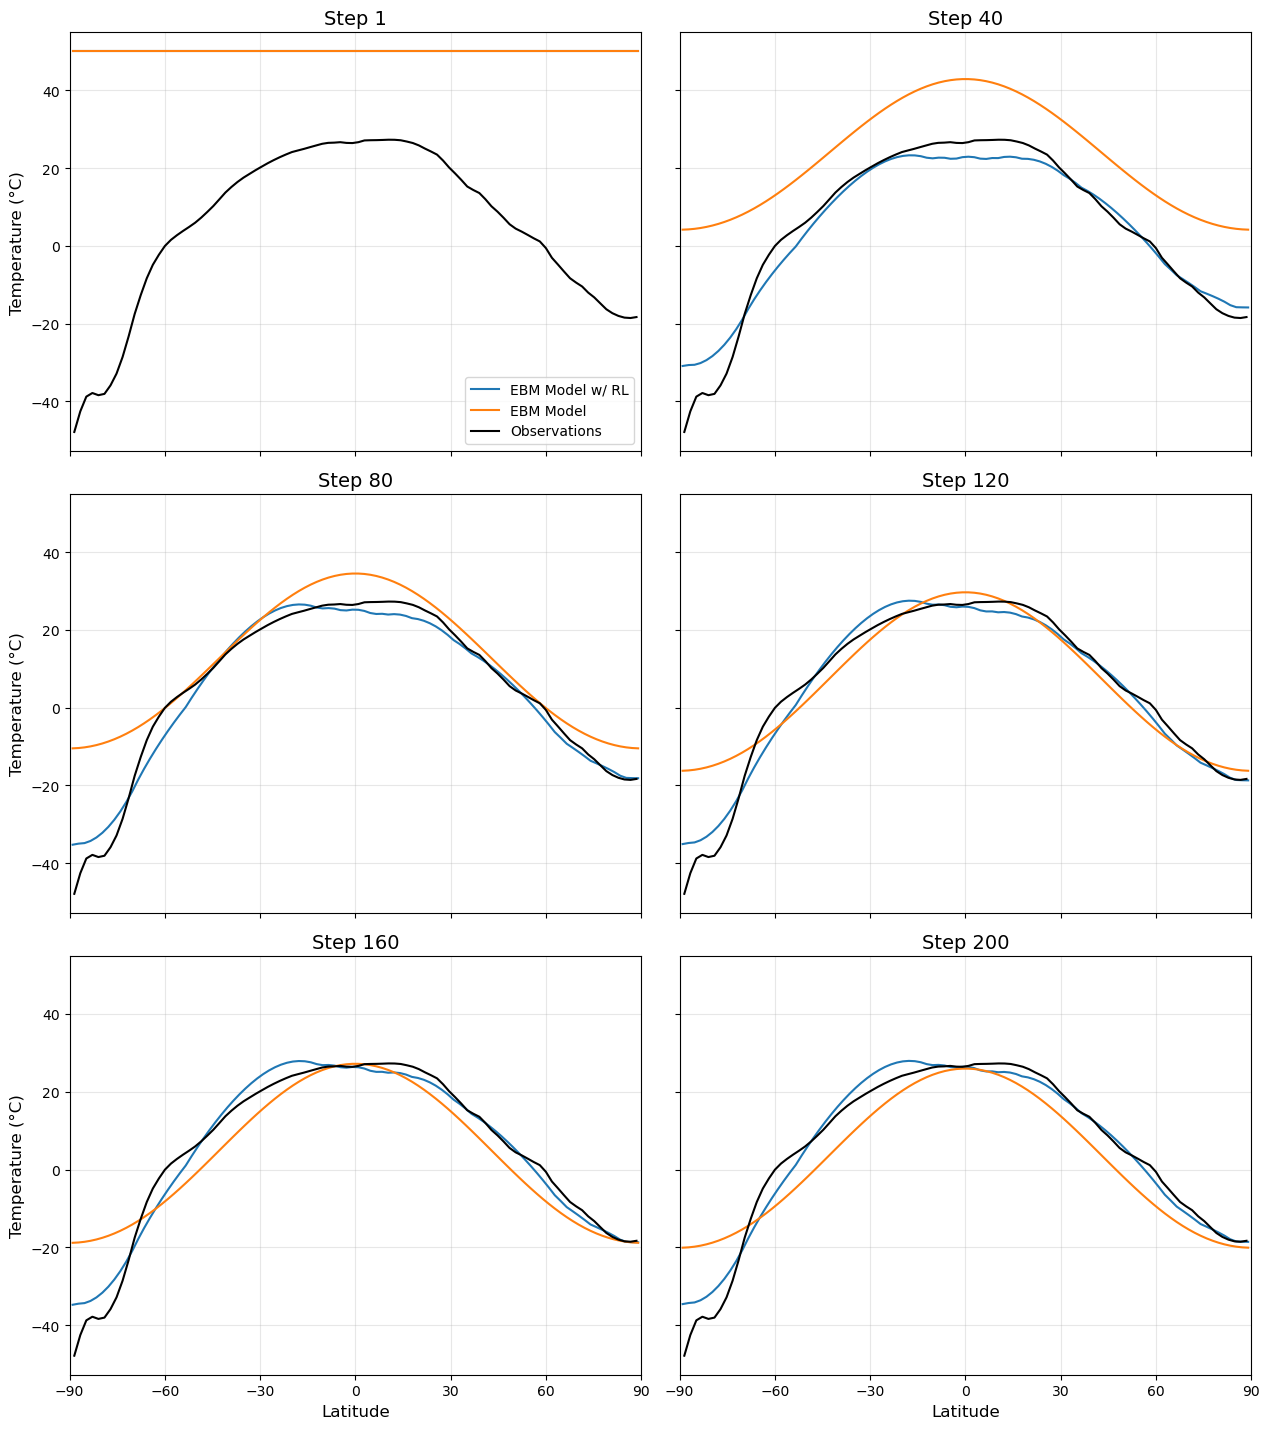

In [8]:
idx = [0, 39, 79, 119, 159, 199]

fig, axes = plt.subplots(
    3, 2, figsize=(6.4 * 2, 4.8 * 3), sharex=True, sharey=True
)
axes = axes.ravel()

ebm_lat = climlab_ebm.lat
obs_lat = lat_ncep
obs_ts = Ts_ncep_annual

for ax, step in zip(axes, idx):
    ebm_Ts = ebm_dict[200]["obs"][step].reshape(-1)
    clim_ts = climlab_ebm_obs[step].reshape(-1)
    ax.plot(ebm_lat, ebm_Ts, label="EBM Model w/ RL")
    ax.plot(ebm_lat, clim_ts, label="EBM Model")
    ax.plot(obs_lat, obs_ts, label="Observations", c="k")
    ax.set_title(f"Step {step+1}", fontsize=14)
    ax.set_xlim(-90, 90)
    ax.set_xticks(np.arange(-90, 91, 30))
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis="both", which="major", labelsize=10)

axes[0].legend(loc="best", fontsize=10)

for ax in axes[4:]:
    ax.set_xlabel("Latitude", fontsize=12)
for ax in axes[0::2]:
    ax.set_ylabel("Temperature (°C)", fontsize=12)

fig.tight_layout()

for ext in ["pdf", "png"]:
    plt.savefig(
        f"{IMGS_DIR}/{ext}/{EXP_ID}_{RL_ALGO}_{SEED}_ebm_state_evolution.{ext}",
        dpi=300,
        bbox_inches="tight",
    )